In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses or sigma:
        plt.subplot(122)
        plt.title('fidelity')
    if losses:
        plt.plot(losses, 'g')
    if sigma:
        plt.plot(sigma, 'r')
    plt.show()

In [4]:
# (action, reward) distribution for a given "spectator measurement outcome" state
class Context:
    def __init__(self, num_arms, gamma):
        # correspondingly indexed (reward | state, action) set
        # samples from beta(S, F) distribution
        self.reward_posterior_samples = np.ones(num_arms, dtype=np.float64)
        # (successes | arm)
        self.S = np.ones(num_arms, dtype=np.int)
        # (failures | arm)
        self.F = np.ones(num_arms, dtype=np.int)
        # discount factor
        self.gamma = gamma
        
        self.num_arms = num_arms
        
    def reset(self):
        self.S = np.ones(self.num_arms, dtype=np.int)
        self.F = np.ones(self.num_arms, dtype=np.int)
        
    def update_gamma(self, gamma):
        self.gamma = gamma
        
    def resample_rewards(self):
        # ("Thompson") sampling from beta(S, F) distribution for each arm
        # which enables exploration
        for i in range(len(self.reward_posterior_samples)):
            self.reward_posterior_samples[i] = np.random.beta(self.S[i], self.F[i])

    def discount(self):
        self.S = self.gamma * self.S
        self.F = self.gamma * self.F
        
    def update_posterior(self, reward, arm):
        self.discount()
        self.S[arm] += reward
        self.F[arm] += 1-reward

In [5]:
# contextual Thompson Sampling algorithm implementation
class TS:
    def __init__(self, env, initial_gamma=0.99):
        # two contexts -> pos vs neg rotation with respect to a chosen rotational bias
        self.contexts = [Context(env.num_arms, initial_gamma), Context(env.num_arms, initial_gamma)]
        
        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []
        
        self.num_context_spectators = env.num_context_spectators
        
        self.action_distribution_width = np.pi
        self.action_contextual_bias = 0
        
        
    def get_action(self, observation):
        # our context is an array of binary spectator qubit measurements
        # hence, we could convert this binary array to an integer and index 2^(spectator qubits) contexts
        # context = self.contexts[np.packbits(observation, bitorder='little')[0]] 
        # for now, we only have two contexts (+ vs -), and so we consider spectators to be indistinguishable noise polling devices
        # in the future, we may consider noise gradients and so we do indeed need to track the specific arrangement
        context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
        context = self.contexts[context_idx]
        context.resample_rewards()
        
        ## to update the gamma or action space, use the functions below e.g. _update_action_distribution_width
        ## this will ensure that the contextual history is reset once the historical correspondence between arms and particular thetas is nullified
        
        # (quantile, uniform action distribution width, rotational bias)
        return (np.argmax(context.reward_posterior_samples), self.action_distribution_width, self.action_contextual_bias)
    
    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)
        
    def _update_action_distribution_width(self, width):
        self.action_distribution_width = width
        for context in self.contexts:
            context.reset()
        
    def _update_contextual_bias(self, bias):
        self.update_contextual_bias = bias
        for context in self.contexts:
            context.reset()
    
    def update(self, action, reward, observation):
        arm, _, _ = action
        context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
        context = self.contexts[context_idx]
        context.update_posterior(reward, arm)
            
    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)
        
    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)

In [10]:
M = 100


# add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
error_samples = np.random.normal(0, np.pi / 4, M) # + time_dependent_fn(np.arange(M))

In [11]:
from spectator_env import SpectatorEnv

# describes MDP
# - states are given in terms of a 64 bit measurement outcomes
# - action space is given by (num_arms, uniform_action_space_width, contextual_measurement_bias) i.e. \ZZ_{num_arms} \times U(1) \times U(1)
env = SpectatorEnv(error_samples, num_context_spectators=64, num_reward_spectators=64, num_arms=5)

# from stable_baselines.common.env_checker import check_env
# check_env(env)

In [12]:
# print(error_samples)

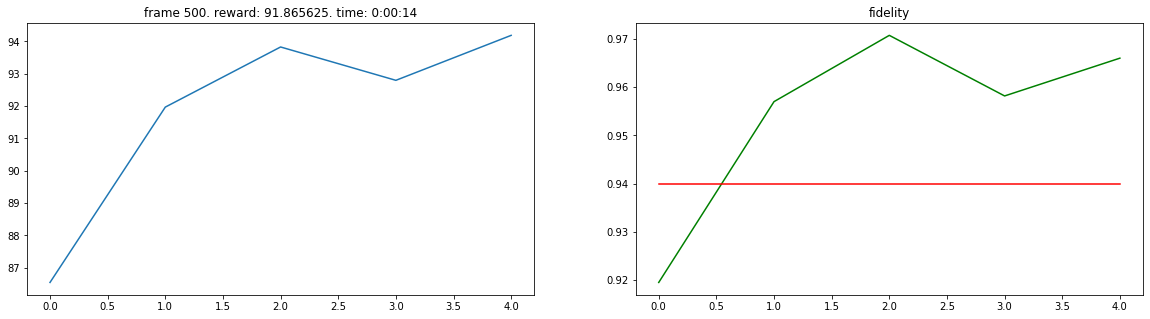

In [13]:
start=timer()

ts = TS(env, initial_gamma=1.0)

episode_reward = 0
episode_fidelity = []
control_fidelity = []

MAX_FRAMES = 5 * M

# "episodes" are a reasonable way to think about learning a periodic time dependent function
# max frames = episode length * num episodes
# episodes are identical sequences of training data
observation = env.reset()
for frame_idx in range(1, MAX_FRAMES + 1):
#     epsilon = config.epsilon_by_frame(frame_idx)
    
    action = ts.get_action(observation)
    prev_observation = observation
#     print("prev obs: ", prev_observation)
#     print("action: ", action)
    observation, reward, done, info = env.step(action)
#     print("reward: ", reward)
    observation = None if done else observation

    # generally, in RL we would consider r(s | s', a) given a state transition s' -> s due to action a
    # for now, we are only interested in r(s', a)
    ts.update(action, reward, prev_observation)
#     print(ts.contexts[0].S, ts.contexts[0].F)
#     print(ts.contexts[1].S, ts.contexts[1].F)
    episode_reward += reward
    
    episode_fidelity.append(info[0])
    control_fidelity.append(info[1])

    if done:
        observation = env.reset()
        ts.save_reward(episode_reward)
        ts.save_fidelity(np.mean(episode_fidelity))
        ts.save_control_fidelity(np.mean(control_fidelity))
        episode_reward = 0
        episode_fidelity = []
        control_fidelity = []
        
        # plot grouped by episode
        plot(frame_idx, ts.rewards, ts.fidelity, ts.control_fidelity, timedelta(seconds=int(timer()-start)))
        

env.close()


In [14]:
print(ts.contexts[0].S, ts.contexts[0].F)
print(ts.contexts[0].reward_posterior_samples)

[  8.078125 227.0625    33.90625    4.984375   1.3125  ] [ 2.921875 11.9375    5.09375   3.015625  2.6875  ]
[0.81292982 0.9509719  0.89992853 0.67584071 0.2657302 ]


In [15]:
print(ts.contexts[1].S, ts.contexts[1].F)
print(ts.contexts[1].reward_posterior_samples)

[  1.53125    5.640625  20.828125 157.71875    8.265625] [ 3.46875   3.359375  4.171875 10.28125   3.734375]
[0.14082383 0.4102947  0.81127294 0.94298673 0.68077038]
